In [1]:
from ucb import LinUCB
from oracle import LinearOracle, OnlineRandomForestOracle, NeuralOracle, GPOracle, AdaptiveOracle
from ucb import NeuralUCB, NeuralTS, LinUCB
import torch
import joblib
import pandas as pd

In [2]:
offline_placebo_model = joblib.load("/Users/mjablons/Documents/strokes/rewarder/placebo_ohs6_predictor.pkl")
offline_treatment_model = joblib.load("/Users/mjablons/Documents/strokes/rewarder/treat_ohs6_predictor.pkl")

In [3]:
df = pd.read_csv('data/stroke_data_2000.csv')

In [4]:
df.head()

,ohs6,treatment,pretrialexp,phase,age,randdelay,sbprand,dbprand,weight,glucose,...,visuospat_rand_Unknown,visuospat_rand_Yes,brainstemsigns_rand_Unknown,brainstemsigns_rand_Yes,otherdeficit_rand_Unknown,otherdeficit_rand_Yes,stroketype_Other,stroketype_PACI,stroketype_POCI,stroketype_TACI
0,1.000000,0,0.809606,-3.378978,0.930334,-0.320712,0.637048,1.201647,0.169181,NaN,...,True,False,True,False,True,False,False,True,False,False
1,0.833333,1,-1.234669,0.295828,-2.470784,-0.416129,-0.887960,-0.717437,-0.165178,-0.918008,...,False,False,False,False,False,False,False,True,False,False
2,0.666667,0,-1.234669,0.295828,-2.312592,1.246842,-1.481019,NaN,1.774104,-0.106904,...,False,True,False,False,False,False,False,True,False,False
3,0.833333,0,0.809606,0.295828,-0.256102,-0.184403,-0.549070,2.092651,-0.499536,-0.512456,...,False,False,False,False,False,False,False,True,False,False
4,0.333333,1,-1.234669,0.295828,-1.047060,1.410412,1.272469,0.858954,0.904771,-0.512456,...,False,False,False,False,False,False,False,False,False,False


In [9]:
import pandas as pd
df = pd.read_csv('data/stroke_data_2000.csv')

context = df.drop(columns=['ohs6', 'treatment']).values.astype(float)
action = df['treatment'].values.astype(float)
reward = df['ohs6'].values.astype(float)

data_stream = list(zip(context, action, reward))

In [10]:
lin_ucb_policy = LinUCB(context.shape[1], 1.0)

In [11]:
import numpy as np
import torch

offline_placebo_model.predict(np.concatenate([[action[0]], context[0]]).reshape(1, -1))

array([0.8821814], dtype=float32)

In [36]:
# Main experimental loop
possible_actions = [0, 1]
results = {}
for policy, policy_name in zip([lin_ucb_policy], ['LinUCB']):
    cumulative_reward = 0
    rewards = []
    cumulative_rewards = []
    regrets = []
    
    for t, (context, true_action, true_reward) in enumerate(data_stream):
        # Select action
        action = policy.select_action(context, possible_actions)
        
        # Get reward (true or imputed)
        if action == true_action:
            reward = true_reward
        else:
            if action == 0: 
                reward = offline_placebo_model.predict(np.concatenate([context, [action]]).reshape(1, -1))
            else:
                reward = offline_treatment_model.predict(np.concatenate([context, [action]]).reshape(1, -1))
        
        # Ensure reward is a scalar
        if isinstance(reward, torch.Tensor):
            reward_scalar = reward.item()
        elif isinstance(reward, np.ndarray):
            reward_scalar = float(reward.squeeze())
        else:
            reward_scalar = reward

        # Update policy
        policy.update(context, action, reward)
        
        # Track reward
        rewards.append(reward_scalar)
        cumulative_reward += reward_scalar
        cumulative_rewards.append(cumulative_reward)
        
        # Regret: difference between best possible reward and received reward
        # Here, true_reward is the reward for the action that was actually taken in the data (the "best" action)
        # If you have access to the true rewards for both actions, you could use max(true_reward_0, true_reward_1)
        # For now, we assume true_reward is the best possible reward for this context
        regret = true_reward - reward_scalar
        regrets.append(regret)
    
    results[policy_name] = {
        "cumulative_reward": cumulative_reward,
        "cumulative_rewards": cumulative_rewards
    }

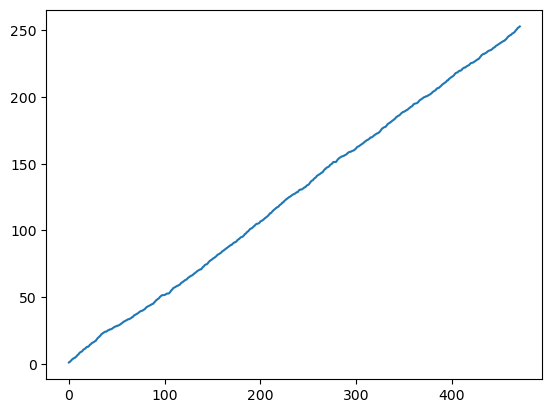

In [39]:
plt.plot(results['LinUCB']['cumulative_rewards'])